In [1]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
in_dim = 1
out_dim = 1
hidden_dim = 512
class GCN(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.conv = GCNConv(in_dim, hidden_dim).to(torch.float64)
        self.linear = nn.Linear(hidden_dim, out_dim).to(torch.float64)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = torch.relu(x)
        x = self.linear(x)
        return x

In [3]:
# Params for dataset
n = 700
p = 0.05
threshold = 0.3
no_digits = 4

# Params for GNN
input_dim = 1
hidden_dim = 128
output_dim = 1

# Params for optimizer
weight_decay = 0.1
lr = 1e-3
betas = (0.9, 0.98)


node_feats = torch.randint(low=10**no_digits, high=10**(no_digits+1), 
                           size=(n,1)).to(torch.float64)

# node_feats = torch.randint(low=10**no_digits, high=10**(no_digits+1), 
#                            size=(n,1)).to(torch.float64)

half_matrix = torch.bernoulli(p * (torch.triu(torch.ones(n, n)) -
                                              torch.eye(n)))
adj_matrix = (half_matrix + half_matrix.T).to(torch.float64)
edge_index = adj_matrix.nonzero().t().contiguous()

# node_labels = torch.Tensor([])
# for i in range(n):
#     total = 0
#     for j in range(n):
#         if adj_matrix[i][j] == 1:
#             total += node_feats[j]
#     node_labels = torch.cat([node_labels, total % 13], dim=0)
# node_labels = node_labels.reshape(-1, 1).to(torch.float64)

node_labels = torch.Tensor([])
for i in range(n):
    total = 0
    for j in range(n):
        if adj_matrix[i][j] == 1:
            total += node_feats[j]
    node_labels = torch.cat([node_labels, total], dim=0)
node_labels = node_labels.reshape(-1, 1).to(torch.float64)


print(node_feats.shape)
print(adj_matrix.shape)
print(node_labels.shape)

torch.Size([700, 1])
torch.Size([700, 700])
torch.Size([700, 1])


In [4]:
import random
poss = [i for i in range(n)]
idx = random.sample(poss, int(threshold * len(poss)))
train_mask = [True if i in idx else False for i in range(n)]
val_mask = [False if train_mask[i] else True for i in range(n)]

In [5]:
from sklearn.metrics import mean_squared_error
model = GCN(in_dim=in_dim, out_dim=out_dim, hidden_dim=hidden_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)

criterion = nn.MSELoss()
node_feats = node_feats.to(torch.float64)
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
    
      out = model(node_feats, edge_index)  # Perform a single forward pass.
      out = out.to(torch.float64)

      loss = criterion(out[train_mask], node_labels[train_mask])  # Compute the loss solely based on the training nodes.
      loss_test = criterion(out[val_mask], node_labels[val_mask])
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, loss_test

def test():
      model.eval()
      pred = model(node_feats, edge_index)
      #pred = pred.argmax(dim=1)  # Use the class with highest probability.
      #true = node_labels.argmax(dim=1)
    
#       test_acc = torch.sqrt(torch.mean((pred[val_mask] - node_labels[val_mask]) ** 2))
#       train_acc = torch.sqrt(torch.mean((pred[train_mask] - node_labels[train_mask]) ** 2))

    
#       return test_acc.item(), train_acc.item()
      return (mean_squared_error(node_labels[val_mask].detach(), pred[val_mask].detach()),
            mean_squared_error(node_labels[train_mask].detach(), pred[train_mask].detach()))

# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(node_feats, adj_matrix)  # Perform a single forward pass.
#       loss = criterion(out[train_mask], node_labels[train_mask])  # Compute the loss solely based on the training nodes.
#       loss_test = criterion(out[val_mask], node_labels[val_mask])
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss, loss_test

# def test():
#       model.eval()
#       out = model(node_feats, adj_matrix)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       true = node_labels.argmax(dim=1)
#       test_correct = pred[val_mask] == true[val_mask]  # Check against ground-truth labels.
#       test_acc = int(np.array(test_correct).sum()) / int(np.array(val_mask).sum())  # Derive ratio of correct predictions.


#       train_correct = pred[train_mask] == true[train_mask]  # Check against ground-truth labels.
#       train_acc = int(np.array(train_correct).sum()) / int(np.array(train_mask).sum())  # Derive ratio of correct predictions.
#       return test_acc, train_acc
import tqdm.auto as tqdm
train_loss = []
test_loss = []
test_aa = []
train_aa = []
for epoch in tqdm.tqdm(range(10000)):
#     if epoch % 100 == 0:
#       print(epoch)
    loss, loss_test = train()
    test_acc, train_acc = test()
    train_loss.append(loss.item())
    test_loss.append(loss_test.item())
    test_aa.append(test_acc)
    train_aa.append(train_acc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:08<00:00, 12.69it/s]


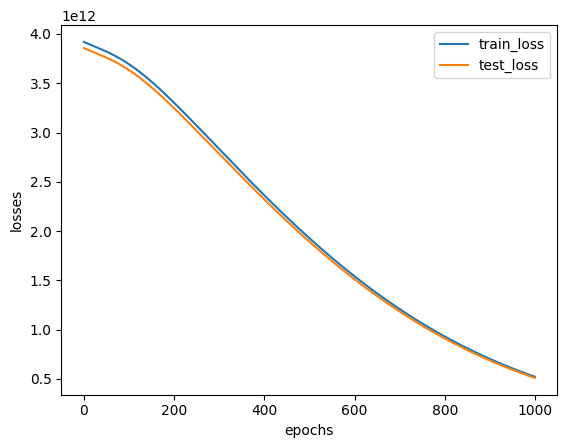

In [39]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(test_loss)
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(['train_loss', 'test_loss'])

In [40]:
import numpy as np

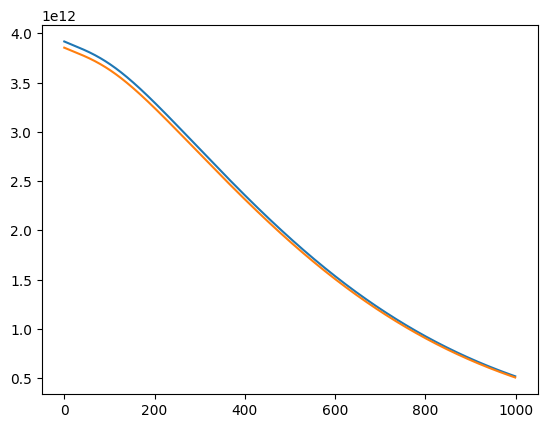

In [41]:
plt.plot(range(len(train_aa)), np.array(train_aa))
plt.plot(range(len(test_aa)), np.array(test_aa))

In [6]:
#path = '/Users/.../Desktop/gdl_exam/figs/'
torch.save(torch.Tensor(train_aa), path + '5train_gcn_01.pt')
torch.save(torch.Tensor(test_aa), path + '5test_gcn_01.pt')